In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


# Running on XX cell types

In [3]:
adata_pb = sc.read('./pb_adata_LPC_sep.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 127 × 19304
    obs: 'publication', 'label', 'cell_type', 'replicate_cat', 'sample', 'sample_rep', 'batch', 'lib_size', 'log_lib_size', 'replicate'
    uns: 'cell_type_colors', 'label_colors', 'log1p', 'pca', 'publication_colors', 'replicate_cat_colors', 'sample_colors', 'sample_rep_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'label']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'label']).size().unstack(fill_value=0)
summary_table

label,ctrl,stim
cell_type,,
COPs,3,6
MFOLs,5,5
MOL_A,3,3
MOL_B,5,9
MOL_C,5,8
MOL_D,5,9
MOL_E,4,9
MOL_F,3,9
MOL_G,3,3


In [5]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['MOL_D', 'MOL_F'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (26, 19304)


In [6]:
pub_map = {
    '(this study)': 'Adams',
    'Pandey et al. 2022': 'Pandey'
}

# Update the 'treatment_meta' column based on the mapping
adata_sub.obs['batch'] = adata_sub.obs['publication'].map(pub_map)

In [7]:
# Concatenate 'individual_lesion_condition' and 'replicate' to create 'sample'
adata_sub.obs['cell_type_sample'] = adata_sub.obs['cell_type'].astype(str) + '_' + adata_sub.obs['sample_rep'].astype(str)

In [8]:
adata_sub.obs[:5]

,publication,label,cell_type,replicate_cat,sample,sample_rep,batch,lib_size,log_lib_size,replicate,cell_type_sample
donor_ctrl_1_0-1-0-0-0,(this study),ctrl,MOL_D,1,ctrl_1,LPC_Saline_2,Adams,358851,12.790663,1,MOL_D_LPC_Saline_2
donor_ctrl_2_0-1-0-0-0,(this study),ctrl,MOL_D,2,ctrl_2,LPC_Saline_1,Adams,709876,13.472846,2,MOL_D_LPC_Saline_1
donor_ctrl_3_0-1-0-0-0,Pandey et al. 2022,ctrl,MOL_D,3,ctrl_3,LPC_ctrl_3,Pandey,2775671,14.836403,3,MOL_D_LPC_ctrl_3
donor_ctrl_4_0-1-0-0-0,Pandey et al. 2022,ctrl,MOL_D,4,ctrl_4,LPC_ctrl_2,Pandey,8636551,15.971514,4,MOL_D_LPC_ctrl_2
donor_ctrl_5_0-1-0-0-0,Pandey et al. 2022,ctrl,MOL_D,5,ctrl_5,LPC_ctrl_1,Pandey,6002958,15.607763,5,MOL_D_LPC_ctrl_1


# Subset for demyelination and remyelination MOL2 data

In [9]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['cell_type_sample'].unique()
for condition in unique_conditions:
    print(condition)

MOL_D_LPC_Saline_2
MOL_D_LPC_Saline_1
MOL_D_LPC_ctrl_3
MOL_D_LPC_ctrl_2
MOL_D_LPC_ctrl_1
MOL_D_LPC_7d_2
MOL_D_LPC_7d_1
MOL_D_LPC_5d_1
MOL_D_LPC_5d_3
MOL_D_LPC_28d_3
MOL_D_LPC_28d_1
MOL_D_LPC_5d_2
MOL_D_LPC_28d_2
MOL_D_LPC_5d_4
MOL_F_LPC_Saline_2
MOL_F_LPC_Saline_1
MOL_F_LPC_ctrl_2
MOL_F_LPC_7d_2
MOL_F_LPC_7d_1
MOL_F_LPC_5d_1
MOL_F_LPC_5d_3
MOL_F_LPC_28d_3
MOL_F_LPC_28d_1
MOL_F_LPC_5d_2
MOL_F_LPC_28d_2
MOL_F_LPC_5d_4


In [10]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_type_sample'], 
                           [
                              'MOL_D_LPC_Saline_2',
                                'MOL_D_LPC_Saline_1',
                                'MOL_D_LPC_ctrl_3',
                                'MOL_D_LPC_ctrl_2',
                                'MOL_D_LPC_ctrl_1',
                                'MOL_F_LPC_7d_2',
                                'MOL_F_LPC_7d_1',
                                'MOL_F_LPC_5d_1',
                                'MOL_F_LPC_5d_3',
                                'MOL_F_LPC_5d_2',
                                'MOL_F_LPC_5d_4',
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (11, 19304)


In [11]:
# Check if the 'sample_rep' column exists
if 'sample_rep' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_rep', inplace=True)
else:
    print("The column 'sample_rep' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [12]:
adata_sub.obs

,publication,label,cell_type,replicate_cat,sample,batch,lib_size,log_lib_size,replicate,cell_type_sample
LPC_Saline_2,(this study),ctrl,MOL_D,1,ctrl_1,Adams,358851,12.790663,1,MOL_D_LPC_Saline_2
LPC_Saline_1,(this study),ctrl,MOL_D,2,ctrl_2,Adams,709876,13.472846,2,MOL_D_LPC_Saline_1
LPC_ctrl_3,Pandey et al. 2022,ctrl,MOL_D,3,ctrl_3,Pandey,2775671,14.836403,3,MOL_D_LPC_ctrl_3
LPC_ctrl_2,Pandey et al. 2022,ctrl,MOL_D,4,ctrl_4,Pandey,8636551,15.971514,4,MOL_D_LPC_ctrl_2
LPC_ctrl_1,Pandey et al. 2022,ctrl,MOL_D,5,ctrl_5,Pandey,6002958,15.607763,5,MOL_D_LPC_ctrl_1
LPC_7d_2,(this study),stim,MOL_F,1,stim_1,Adams,184841,12.127251,1,MOL_F_LPC_7d_2
LPC_7d_1,(this study),stim,MOL_F,2,stim_2,Adams,223894,12.318928,2,MOL_F_LPC_7d_1
LPC_5d_1,Pandey et al. 2022,stim,MOL_F,3,stim_3,Pandey,2119084,14.566494,3,MOL_F_LPC_5d_1
LPC_5d_3,Pandey et al. 2022,stim,MOL_F,4,stim_4,Pandey,4564697,15.333863,4,MOL_F_LPC_5d_3
LPC_5d_2,Pandey et al. 2022,stim,MOL_F,7,stim_7,Pandey,2177503,14.593689,7,MOL_F_LPC_5d_2


# Rename the MOL clusters for NEW letter based nomenclature

In [13]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[  0   0   2   0   3]
 [  3   0   3   2   3]
 [  3   0 120   2  42]
 [  2   0 479   7 114]
 [  2   0 173  10  50]]


# Start R code: QC of log transformation

In [14]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$label #ctrl or stim
replicate <- colData(adata_sub)$replicate #replicate number
batch <- colData(adata_sub)$batch

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"= batch)
print(treatments)

             Group Reps  Batch
LPC_Saline_2  ctrl    1  Adams
LPC_Saline_1  ctrl    2  Adams
LPC_ctrl_3    ctrl    3 Pandey
LPC_ctrl_2    ctrl    4 Pandey
LPC_ctrl_1    ctrl    5 Pandey
LPC_7d_2      stim    1  Adams
LPC_7d_1      stim    2  Adams
LPC_5d_1      stim    3 Pandey
LPC_5d_3      stim    4 Pandey
LPC_5d_2      stim    7 Pandey
LPC_5d_4      stim    9 Pandey


In [15]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$label)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 19304    11

ctrl stim 
   5    6 


In [16]:
%%R

cd <- x$samples$group
print(cd)

 [1] ctrl ctrl ctrl ctrl ctrl stim stim stim stim stim stim
Levels: ctrl stim


In [17]:
%%R

# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       1      0
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
11      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [18]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 9677   11


In [19]:
%%R

## OLD DON"T USE THIS

keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 10283    11


In [20]:
%%R
#X is before trimming, Y is after trimming
L <- mean(x2$samples$lib.size) * 1e-6
M <- median(x2$samples$lib.size) * 1e-6
c(L, M)

[1] 2.552464 2.105341


In [21]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

 [1] 1.3106180 1.3179254 0.9305017 0.9876606 0.9796875 1.2370719 1.1672143
 [8] 0.8910602 0.7411050 0.8079643 0.8346341


In [22]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

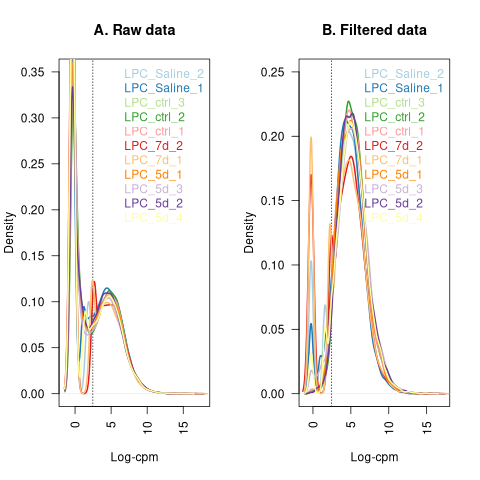

In [23]:
%%R
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x2)
col <- brewer.pal(nsamples, "Paired")

par(mfrow=c(1,2))

lcpm <- edgeR::cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.35), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

lcpm <- edgeR::cpm(x2, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.25), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

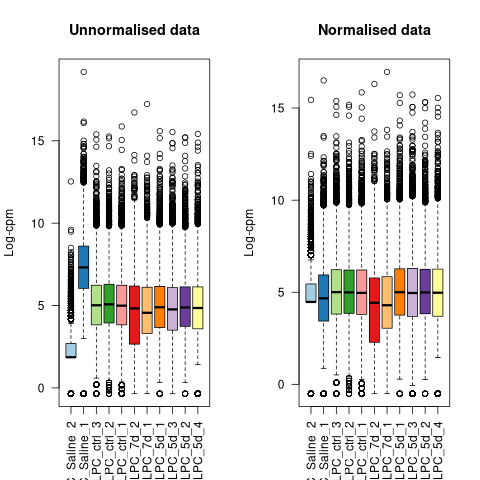

In [24]:
%%R
y2 <- x2
y2$samples$norm.factors <- 1
y2$counts[,1] <- ceiling(y2$counts[,1]*0.05)
y2$counts[,2] <- y2$counts[,2]*5

par(mfrow=c(1,2))
lcpm <- edgeR::cpm(y2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Unnormalised data", ylab="Log-cpm")

y3 <- calcNormFactors(y2)
y3$samples$norm.factors

lcpm <- edgeR::cpm(y3, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Normalised data", ylab="Log-cpm")

# Show how log transf + batch removal affects the separation of samples:

In [25]:
%%R
#Make new count matrix with log counts and DGE data from X2 (trimmed, normfactors)
x3 <- x2
x3$counts <- lcpm

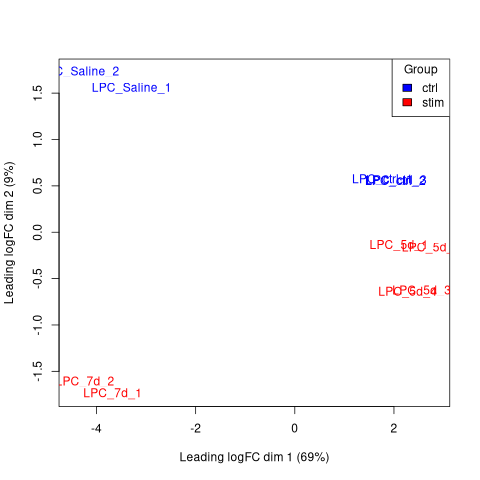

In [26]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

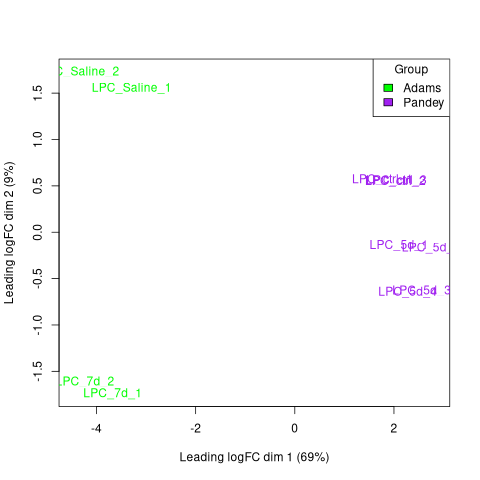

In [27]:
%%R
# Generate a numeric vector from group factors (if not already factor, convert it)
pub_factor <- as.factor(batch)
pub_colors <- as.numeric(pub_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("green", "purple")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[pub_colors])

# Adding a legend for clarity
legend("topright", legend=levels(pub_factor), fill=colors, title="Group")

In [28]:
%%R

x3$samples

             group lib.size norm.factors
LPC_Saline_2  ctrl   351027    1.3106180
LPC_Saline_1  ctrl   693727    1.3179254
LPC_ctrl_3    ctrl  2757168    0.9305017
LPC_ctrl_2    ctrl  8572853    0.9876606
LPC_ctrl_1    ctrl  5962866    0.9796875
LPC_7d_2      stim   181124    1.2370719
LPC_7d_1      stim   219411    1.1672143
LPC_5d_1      stim  2105341    0.8910602
LPC_5d_3      stim  4539300    0.7411050
LPC_5d_2      stim  2159904    0.8079643
LPC_5d_4      stim   534379    0.8346341


In [29]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       1      0
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
11      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [30]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


In [31]:
%%R
# Convert to CPM and log2 transformation. 
logCPM <- edgeR::cpm(x2, log=TRUE, prior.count=3)

In [32]:
%%R
#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch <- removeBatchEffect(logCPM, batch=batch) 

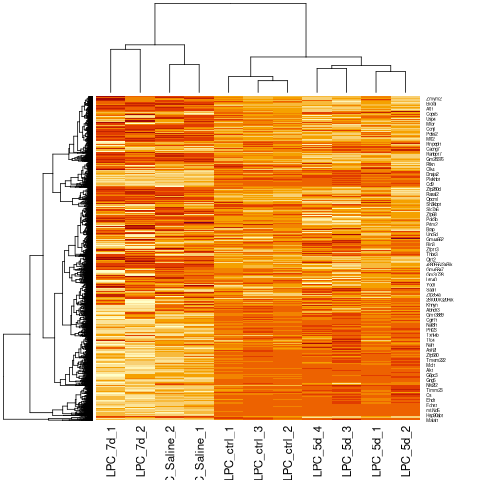

In [33]:
%%R
heatmap(logCPM)

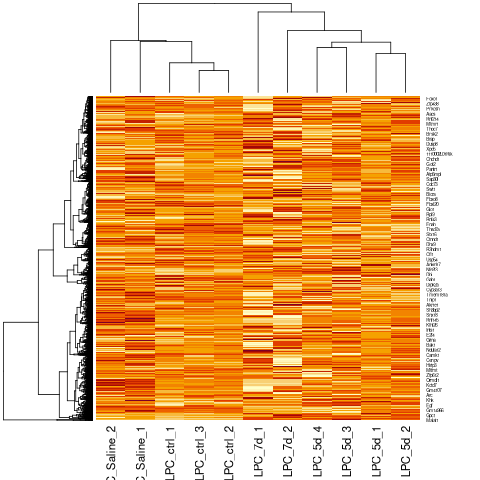

In [34]:
%%R
heatmap(logCPM_no_batch)

# Voom with quality weights

In [35]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


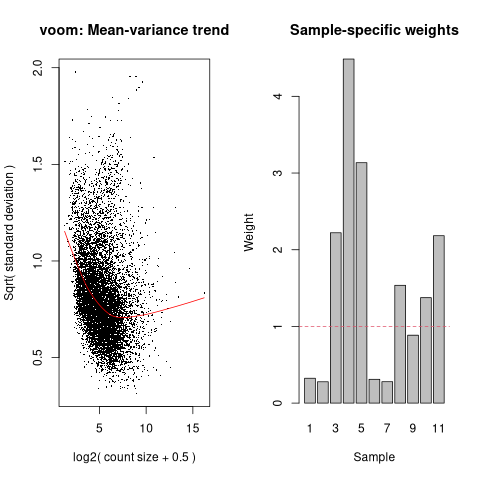

In [36]:
%%R
y <- voomWithQualityWeights(x2$counts, design, plot=TRUE)

In [37]:
%%R
corfit <- duplicateCorrelation(y, design, block=batch)
corfit$consensus.correlation

[1] 0.4776032


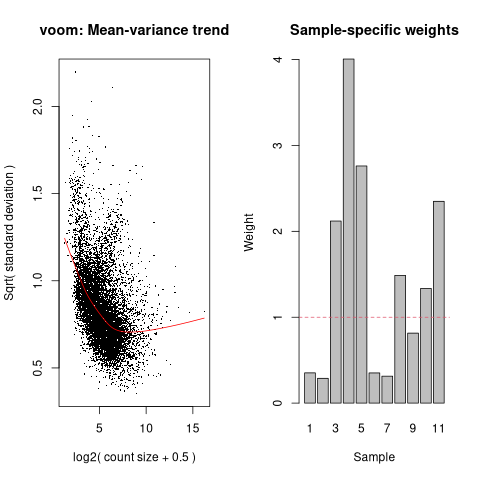

In [38]:
%%R
y2 <- voomWithQualityWeights(x2$counts, design, plot=TRUE, block=batch, correlation=corfit$consensus)

In [39]:
%%R
corfit2 <- duplicateCorrelation(y2,design,block=batch, weights=y2$targets$sample.weights)
corfit2$consensus.correlation

[1] 0.6158048


In [40]:
%%R
fit <- lmFit(y2, design, block=batch, correlation=corfit2$consensus)

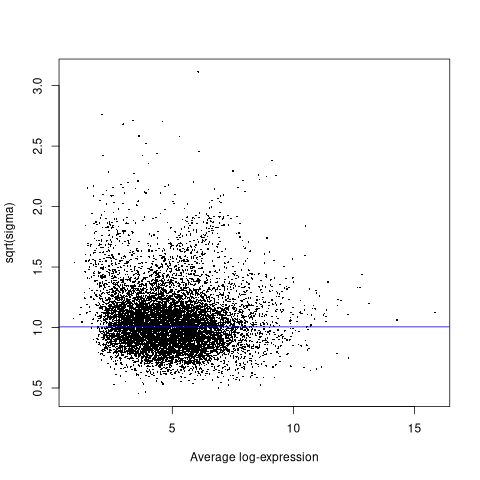

In [41]:
%%R
contr <- makeContrasts(cdstim - cdctrl, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [42]:
%%R
# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

                 logFC  AveExpr        t      P.Value    adj.P.Val        B
Serpina3n     6.533785 6.775086 28.63736 1.130871e-13 1.094344e-09 21.54591
Pros1         3.780291 4.164128 24.83927 7.753378e-13 3.162973e-09 19.50304
Fam13c        3.733416 6.483897 24.41059 9.805640e-13 3.162973e-09 19.51768
Il33          2.665567 8.585220 19.61067 1.848409e-11 4.471764e-08 16.73227
Slc9a3r2      5.584361 4.426395 18.22433 4.899760e-11 9.482996e-08 15.72774
Gpd1          3.211838 7.230794 17.93574 6.054159e-11 9.764349e-08 15.58027
C4b           4.325982 6.921060 17.29050 9.829188e-11 1.358815e-07 15.10511
2310002F09Rik 7.304276 3.717309 16.79647 1.440761e-10 1.742780e-07 13.78335
Gm45338       3.325553 2.905228 16.31679 2.109432e-10 2.060354e-07 14.21919
Cebpd         3.710691 4.581278 16.30525 2.129125e-10 2.060354e-07 14.32758


In [43]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 897


In [50]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 0.7, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 744


In [44]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 1, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 503


In [45]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 271
                  logFC  AveExpr         t      P.Value    adj.P.Val         B
Klk8          10.220585 3.055443  8.267315 1.043207e-06 1.134282e-04  5.835454
Socs3          7.746544 2.542192  9.251554 2.765975e-07 4.182240e-05  7.048959
2310002F09Rik  7.304276 3.717309 16.796468 1.440761e-10 1.742780e-07 13.783350
Anxa2          7.164737 2.574647 11.389640 2.154920e-08 5.346964e-06  9.488319
Rgs20          7.163956 1.382265 11.006286 3.305641e-08 7.379971e-06  8.907915
Steap3         6.699858 1.471702 13.825151 1.827602e-09 8.842852e-07 11.436299


In [46]:
%%R
if ('C4b' %in% rownames(genes_up_sorted)) {
    print("C4b is in the index of genes_up_sorted")
} else {
    print("C4b is not in the index of genes_up_sorted")
}

[1] "C4b is in the index of genes_up_sorted"


In [47]:
%%R
if ('Serpina3n' %in% rownames(genes_up_sorted)) {
    print("Serpina3n is in the index of genes_up_sorted")
} else {
    print("Serpina3n is not in the index of genes_up_sorted")
}

[1] "Serpina3n is in the index of genes_up_sorted"


In [48]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 232
                  logFC  AveExpr         t      P.Value   adj.P.Val          B
Itgb5         -5.951247 2.778707 -5.310634 1.161670e-04 0.003997259  1.4494286
A530053G22Rik -4.830190 3.489707 -4.776175 3.088102e-04 0.008120533  0.5218326
Irak2         -3.996585 1.901343 -5.070833 1.793110e-04 0.005439474  1.0012981
Gm13052       -3.784197 2.982261 -3.714652 2.368479e-03 0.032055627 -1.3379249
Art3          -3.502168 3.104124 -5.611397 6.813822e-05 0.002658764  1.8901109
1700063D05Rik -3.416080 4.518616 -6.323959 2.023576e-05 0.001085290  3.0942879


In [49]:
%%R
head(tt)

             logFC  AveExpr        t      P.Value    adj.P.Val        B
Serpina3n 6.533785 6.775086 28.63736 1.130871e-13 1.094344e-09 21.54591
Pros1     3.780291 4.164128 24.83927 7.753378e-13 3.162973e-09 19.50304
Fam13c    3.733416 6.483897 24.41059 9.805640e-13 3.162973e-09 19.51768
Il33      2.665567 8.585220 19.61067 1.848409e-11 4.471764e-08 16.73227
Slc9a3r2  5.584361 4.426395 18.22433 4.899760e-11 9.482996e-08 15.72774
Gpd1      3.211838 7.230794 17.93574 6.054159e-11 9.764349e-08 15.58027


# Save output- make sure to rename!

In [51]:
%%R
# Add rownames as a proper column, but ensure we do not have duplicates
tt$gene <- rownames(tt)

# Remove rownames to avoid duplication when saving
rownames(tt) <- NULL

# Write to CSV file
write.table(tt, file = "./files/LPC_demyel_MOL_DvF_voom_wqw_NEW.csv", 
            row.names = FALSE, sep = ",", quote = FALSE)

# Check the first few rows to confirm the structure
head(tt)

     logFC  AveExpr        t      P.Value    adj.P.Val        B      gene
1 6.533785 6.775086 28.63736 1.130871e-13 1.094344e-09 21.54591 Serpina3n
2 3.780291 4.164128 24.83927 7.753378e-13 3.162973e-09 19.50304     Pros1
3 3.733416 6.483897 24.41059 9.805640e-13 3.162973e-09 19.51768    Fam13c
4 2.665567 8.585220 19.61067 1.848409e-11 4.471764e-08 16.73227      Il33
5 5.584361 4.426395 18.22433 4.899760e-11 9.482996e-08 15.72774  Slc9a3r2
6 3.211838 7.230794 17.93574 6.054159e-11 9.764349e-08 15.58027      Gpd1


# Do results overlap with LR pairs?

In [52]:
import liana as li

In [53]:
lr_pairs = li.resource.select_resource('mouseconsensus')
lr_pairs.head()

,ligand,receptor
31371,Dll1,Notch1
31372,Dll1,Notch2
31373,Dll1,Notch4
31374,Dll1,Notch3
31375,Nrg2,Erbb2_Erbb3


In [54]:
DEG_all = pd.read_csv('./files/LPC_demyel_MOL_DvF_voom_wqw_NEW.csv', index_col=None)
DEG_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
DEG_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
DEG_all.shape

(9677, 7)

In [55]:
sigs = DEG_all[(DEG_all.Padj < 0.05) & (abs(DEG_all.logFC) >= 1)]
sigs.shape

(503, 7)

In [56]:
lr_pairs.shape

(3989, 2)

In [57]:
sigs.head()

,logFC,AveExpr,t,Pvalue,Padj,B,gene
0,6.533785,6.775086,28.637363,1.130871e-13,1.094344e-09,21.545910,Serpina3n
1,3.780291,4.164128,24.839267,7.753378e-13,3.162973e-09,19.503035,Pros1
2,3.733416,6.483897,24.410593,9.805640e-13,3.162973e-09,19.517683,Fam13c
3,2.665567,8.585220,19.610675,1.848409e-11,4.471764e-08,16.732271,Il33
4,5.584361,4.426395,18.224327,4.899760e-11,9.482996e-08,15.727740,Slc9a3r2


In [58]:
ligands = lr_pairs['ligand'].unique()
receptors = lr_pairs['receptor'].unique()

# Combining both ligands and receptors and keeping only unique values
unique_genes = set(ligands).union(set(receptors))

# Checking for overlap with 'sigs' dataframe on the 'gene' column
overlap_genes = sigs[sigs['gene'].isin(unique_genes)]
overlap_genes

,logFC,AveExpr,t,Pvalue,Padj,B,gene
1,3.780291,4.164128,24.839267,7.753378e-13,3.162973e-09,19.503035,Pros1
3,2.665567,8.585220,19.610675,1.848409e-11,4.471764e-08,16.732271,Il33
6,4.325982,6.921060,17.290500,9.829188e-11,1.358815e-07,15.105111,C4b
18,2.811370,4.877293,14.045220,1.490261e-09,7.590132e-07,12.407283,Col16a1
31,2.273921,2.853582,12.206260,8.998683e-09,2.721258e-06,10.609784,Sema4g
...,...,...,...,...,...,...,...
717,-2.165877,3.005424,-3.708993,2.394938e-03,3.224164e-02,-1.364301,Lrp11
744,-1.759316,4.840420,-3.661518,2.629070e-03,3.414967e-02,-1.899528,Ldlr
762,-1.029893,4.726201,-3.623732,2.831895e-03,3.591644e-02,-1.971664,Lgr4
774,-1.467157,4.399847,-3.584829,3.057268e-03,3.817443e-02,-1.889991,Cd46


In [59]:
# Checking the direction of logFC for the overlapping genes
overlap_genes_direction = overlap_genes[['gene', 'logFC']].copy()

# Determine the direction of logFC
overlap_genes_direction['logFC_direction'] = overlap_genes_direction['logFC'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Displaying the results
overlap_genes_direction

,gene,logFC,logFC_direction
1,Pros1,3.780291,positive
3,Il33,2.665567,positive
6,C4b,4.325982,positive
18,Col16a1,2.811370,positive
31,Sema4g,2.273921,positive
...,...,...,...
717,Lrp11,-2.165877,negative
744,Ldlr,-1.759316,negative
762,Lgr4,-1.029893,negative
774,Cd46,-1.467157,negative


In [60]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 6


,ligand,receptor,logFC_ligand,logFC_receptor
5,C4b,Cd46,4.325982,-1.467157
1,Apoe,Lrp4,3.786040,1.314653
2,Apoe,Ldlr,3.786040,-1.759316
4,Fgfr4,Epha4,1.929906,1.211658
0,Il1rapl1,Ptprs,-1.019635,1.773109
3,Bmp2,Gpc1,-1.661112,1.698124


In [61]:
sigs_up = DEG_all[(DEG_all.Padj < 0.05) & (DEG_all.logFC >= 1)]
sigs_up.shape

(271, 7)

In [62]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 2


,ligand,receptor,logFC_ligand,logFC_receptor
0,Apoe,Lrp4,3.786040,1.314653
1,Fgfr4,Epha4,1.929906,1.211658


In [ ]:
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('./files/LR_LPC_demyel_MOL_DvF.csv', sep='\t', index=False)